<a href="https://colab.research.google.com/github/fadindashafira/TIAToolBox/blob/main/05_patch_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Patch Prediction Models

In this example, we will show how to use TIAToolbox for patch-level prediction using a range of deep learning models.

TIAToolbox can be used to **make predictions** on **pre-extracted image patches** or on larger image tiles / WSI, where image patches are extracted on the fly.

WSI patch-level predictions can subsequently be aggregated to obtain a segmentation map.

In particular, we will introduce the use of tiatoolbox module `patch_predictor`.

A full list of the available models trained and provided in TIAToolbox for patch-level prediction is given below.

* Models trained on the Kather 100k dataset [(details)](https://zenodo.org/record/1214456#.YJw4UEhKjvU):
* alexnet-kather100k
* resnet18-kather100k
* resnet34-kather100k
* resnet50-kather100k
* resnet101-kather100k
* resnext50_32x4d-kather100k
* resnext101_32x8d-kather100k
* wide_resnet50_2-kather100k
* wide_resnet101_2-kather100k
* densenet121-kather100k
* densenet161-kather100k
* densenet169-kather100k
* densenet201-kather100k
* mobilenet_v2-kather100k
* mobilenet_v3_large-kather100k
* mobilenet_v3_small-kather100k
* googlenet-kather100k

In [4]:
!apt-get -y install libopenjp2-7-dev libopenjp2-tools openslide-tools | tail -n 1
!pip install tiatoolbox | tail -n 1

print("Installation is done.")

Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.0.1 which is incompatible.
google-colab 1.0.0 requires requests==2.27.1, but you have requests 2.30.0 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.3 which is incompatible.
torchaudio 2.0.2+cu118 requires torch==2.0.1, but you have torch 2.0.0 which is incompatible.
torchdata 0.6.1 requires torch==2.0.1, but you have torch 2.0.0 which is incompatible.
torchtext 0.15.2 requires torch==2.0.1, but you have torch 2.0.0 which is incompatible.


Installation is done.


In [1]:
!pip install seaborn

In [1]:
ON_GPU = True  # Set to 'True' or 'False', as appropriate.

## Clean-up before a run
To ensure proper clean-up (for example in abnormal termination), all files downloaded or created in this run are saved in a single directory global_save_dir, which we set equal to "./tmp/". To simplify maintenance, the name of the directory occurs only at this one place, so that it can easily be changed, if desired.

In [2]:
import warnings
import os
import shutil

warnings.filterwarnings("ignore")
global_save_dir = "./tmp/"


def rmdir(dir_path):
    if os.path.isdir(dir_path):
        shutil.rmtree(dir_path)
        print("removing directory ", dir_path)


rmdir(global_save_dir)  # remove  directory if it exists from previous runs
os.mkdir(global_save_dir)
print("creating new directory ", global_save_dir)

removing directory  ./tmp/
creating new directory  ./tmp/


## Importing related libraries
We import some standard Python modules, and also the TIAToolbox Python modules for the patch classification task, written by the TIA Centre team.

In [3]:
from tiatoolbox.models.engine.patch_predictor import (
    PatchPredictor,
    IOPatchPredictorConfig,
)
from tiatoolbox.utils.misc import imread, grab_files_from_dir
from tiatoolbox.utils.visualization import overlay_prediction_mask
from tiatoolbox.wsicore.wsireader import WSIReader
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, glob

mpl.rcParams["figure.dpi"] = 160  # for high resolution figure in notebook
mpl.rcParams["figure.facecolor"] = "white"  # To make sure text is visible in dark mode


## Downloading the required files
We download, over the internet, image files used for the purpose of this notebook. In particular, we download a sample subset of validation patches that were used when training models on the Kather 100k dataset, a sample image tile and a sample whole-slide image. Downloading is needed once in each Colab session and it should take less than 1 minute. In Colab, if you click the file's icon (see below) in the vertical toolbar on the left-hand side then you can see all the files which the code in this notebook can access. The data will appear here when it is downloaded.

In [4]:
from tiatoolbox.utils.misc import download_data
from zipfile import ZipFile

img_file_name = global_save_dir + "sample_tile.png"
wsi_file_name = global_save_dir + "sample_wsi.svs"
patches_file_name = global_save_dir + "kather100k-validation-sample.zip"
imagenet_samples_name = global_save_dir + "imagenet_samples.zip"

print("Download has started. Please wait...")

# Downloading sample image tile
download_data(
    "https://tiatoolbox.dcs.warwick.ac.uk/sample_imgs/CRC-Prim-HE-05_APPLICATION.tif",
    img_file_name,
)

# Downloading sample whole-slide image
download_data(
    "https://tiatoolbox.dcs.warwick.ac.uk/sample_wsis/TCGA-3L-AA1B-01Z-00-DX1.8923A151-A690-40B7-9E5A-FCBEDFC2394F.svs",
    wsi_file_name,
)

# Download a sample of the validation set used to train the Kather 100K dataset
download_data(
    "https://tiatoolbox.dcs.warwick.ac.uk/datasets/kather100k-validation-sample.zip",
    patches_file_name,
)

# Unzip it!
with ZipFile(patches_file_name, "r") as zipObj:
    zipObj.extractall(path=global_save_dir)

# Download some samples of imagenet to test the external models
download_data(
    "https://tiatoolbox.dcs.warwick.ac.uk/sample_imgs/imagenet_samples.zip",
    imagenet_samples_name,
)
# Unzip it!
with ZipFile(imagenet_samples_name, "r") as zipObj:
    zipObj.extractall(path=global_save_dir)

print("Download is complete.")

Download has started. Please wait...
Download from https://tiatoolbox.dcs.warwick.ac.uk/sample_imgs/CRC-Prim-HE-05_APPLICATION.tif
Save to ./tmp/sample_tile.png
Download from https://tiatoolbox.dcs.warwick.ac.uk/sample_wsis/TCGA-3L-AA1B-01Z-00-DX1.8923A151-A690-40B7-9E5A-FCBEDFC2394F.svs
Save to ./tmp/sample_wsi.svs
Download from https://tiatoolbox.dcs.warwick.ac.uk/datasets/kather100k-validation-sample.zip
Save to ./tmp/kather100k-validation-sample.zip
Download from https://tiatoolbox.dcs.warwick.ac.uk/sample_imgs/imagenet_samples.zip
Save to ./tmp/imagenet_samples.zip
Download is complete.


## Get predictions for a set of patches
Below we use tiatoolbox to obtain the model predictions for a set of patches with a pretrained model.

We use patches from the validation subset of Kather 100k dataset. This dataset has already been downloaded in the download section above. We first read the data and convert it to a suitable format. In particular, we create a list of patches and a list of corresponding labels. For example, the first label in label_list will indicate the class of the first image patch in patch_list.

Class ID: 0 -- Class Name: BACK -- Number of images: 211
Class ID: 1 -- Class Name: NORM -- Number of images: 176
Class ID: 2 -- Class Name: DEB -- Number of images: 230
Class ID: 3 -- Class Name: TUM -- Number of images: 286
Class ID: 4 -- Class Name: ADI -- Number of images: 208
Class ID: 5 -- Class Name: MUC -- Number of images: 178
Class ID: 6 -- Class Name: MUS -- Number of images: 270
Class ID: 7 -- Class Name: STR -- Number of images: 209
Class ID: 8 -- Class Name: LYM -- Number of images: 232
Total number of patches: 2000


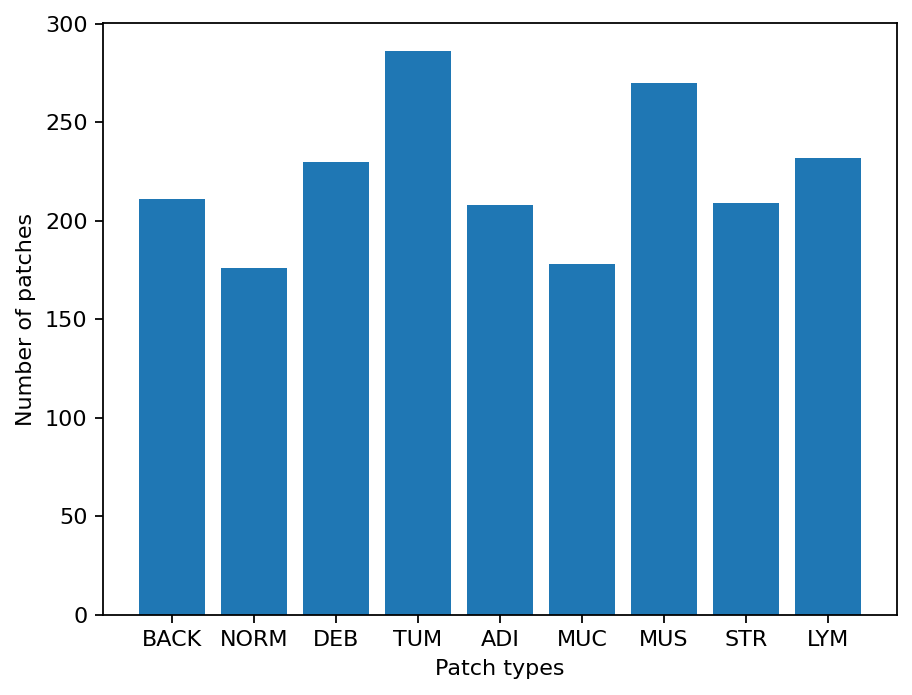

In [5]:
# read the patch data and create a list of patches and a list of corresponding labels

dataset_path = (
    global_save_dir + "/kather100k-validation-sample/"
)  # set the path to the dataset
image_ext = ".tif"  # file extension of each image

# obtain the mapping between the label ID and the class name
label_dict = {
    "BACK": 0,
    "NORM": 1,
    "DEB": 2,
    "TUM": 3,
    "ADI": 4,
    "MUC": 5,
    "MUS": 6,
    "STR": 7,
    "LYM": 8,
}
class_names = list(label_dict.keys())
class_labels = list(label_dict.values())

# generate a list of patches and generate the label from the filename
patch_list = []
label_list = []
for class_name, label in label_dict.items():
    dataset_class_path = os.path.join(dataset_path, class_name)
    patch_list_single_class = grab_files_from_dir(
        dataset_class_path, file_types="*" + image_ext
    )
    patch_list.extend(patch_list_single_class)
    label_list.extend([label] * len(patch_list_single_class))

# show some dataset statistics
plt.bar(class_names, [label_list.count(label) for label in class_labels])
plt.xlabel("Patch types")
plt.ylabel("Number of patches")

# count the number of examples per class
for class_name, label in label_dict.items():
    print(
        "Class ID: {} -- Class Name: {} -- Number of images: {}".format(
            label, class_name, label_list.count(label)
        )
    )


# overall dataset statistics
print("Total number of patches: {}".format(len(patch_list)))0